# Figures
This Notebook executed codes that generate figures

In [111]:
import logging
import traceback
import numpy as np
import mpg.graph.random_graph as rg
import time
import pandas as pd
import networkx as nx
from yfiles_jupyter_graphs import GraphWidget
import mpg.games.mpg as mpg
from mpg.visualisation.game import MPGVisualisation
import mpg.visualisation.game as vgame
import networkx as nx
import matplotlib.pyplot as plt
import os

DPI=200

class FigureManager:
    def __init__(self,**kwargs):
        self.figures={}
        self.options=kwargs
    def add_option(self,key,value):
        self.options[key]=value
        
    def add_figure(self,name,figure):
        self.figures[name]=figure
        return figure
        
    def new_figure(self,name,gen,*args,**kwargs):
        return self.add_figure(name,gen(*args,**kwargs))
        
    def new_subplot(self,name,*args,**kwargs):
        fig,axz=plt.subplots(*args,**kwargs)
        self.add_figure(name,fig)
        return fig,axz
    
    def save_all(self,path=None):
        if path is None:
            path=""
        for name,figure in self.figures.items():
            figure.savefig(os.path.join(path,name),**self.options)
    
figure_mangager=FigureManager(dpi=DPI)
    

class CSVPayload:
    def __init__(self,path,*options,**kw_options):
        self.path=path
        self.options=options
        self.kw_options=kw_options
        pass
    
    def __call__(self):
        return pd.read_csv(self.path,*self.options,**self.kw_options)

class SparseGraphGenerator:
    def __init__(self,path,T,N,C,seed=25,*options,**kw_options):
        self.path=path
        self.T=T
        self.N=N
        self.C=C
        self.seed=seed
        self.options=options
        self.kw_options=kw_options
    
    def __call__(self):
        for t in range(T):
            for n in N:
                for c in C:
                    p=min(c/n,1)
                    t1 = time.time()
                    rg.gnp_random_mpg(n=n, p=p, seed=seed, method="fast", loops=True, distribution="uniform",
                           low=-1,high=1)
                    t2 = time.time()

                    Z.append({"N": n, "C": c, "time":(t2-t1)})
        sparse_gen=pd.DataFrame(Z)
        sparse_gen.to_csv(self.path,*self.options,**self.kw_options)
        return sparse_gen
    
class DenseGraphGenerator:
    def __init__(self,path,T,N,P,seed=25,*options,**kw_options):
        self.path=path
        self.T=T
        self.N=N
        self.P=P
        self.seed=seed
        self.options=options
        self.kw_options=kw_options
    
    def __call__(self):
        for t in range(T):
            for n in N:
                for p in P:
                    t1 = time.time()
                    rg.gnp_random_mpg(n=n, p=p, seed=seed, method="fast", loops=True, distribution="uniform",
                           low=-1,high=1,threshold=0.5)
                    t2 = time.time()

                    Z.append({"N": n, "P": p, "time":(t2-t1)})
        sparse_gen=pd.DataFrame(Z)
        sparse_gen.to_csv(self.path,*self.options,**self.kw_options)
        return sparse_gen

def generate_graph_bad(n,p,loops,generator,threshold=1):
        min_degree=0
        while min_degree==0:
            min_degree=n
            for u in range(n):
                # The degree of the node u is m
                m = generator.binomial(n, p)
                min_degree=min(min_degree,m)
                # Choose m nodes from the set {0,1,...,n-1} uniformly at random
                if m/n < threshold:
                    A = generator.choice(n, m, replace=False)
                else:
                    V = set(generator.choice(n, n-m, replace=False))
                    A = [ v for v in range(n) if v not in V]
                for v in A:
                    # TODO: Check if this is correct. It should give the correct distribution
                    if not loops and u == v:
                        continue
                    G.add_edge(u, v, weight=generator.random())
        return G   
    
def generate_graph_with_sinks(n,p,loops,generator,threshold=1):
    for u in range(n):
        # The degree of the node u is m
        m = generator.binomial(n, p)
        # Choose m nodes from the set {0,1,...,n-1} uniformly at random
        if m/n < threshold:
            A = generator.choice(n, m, replace=False)
        else:
            V = set(generator.choice(n, n-m, replace=False))
            A = [ v for v in range(n) if v not in V]
        for v in A:
            # TODO: Check if this is correct. It should give the correct distribution
            if not loops and u == v:
                continue
            G.add_edge(u, v, weight=generator.random())
    return G


def generate_graph_without_sinks(n,p,loops,generator,threshold=1):
    for u in range(n):
        m=0
        while m==0:
        # The degree of the node u is m
            m = generator.binomial(n, p)
        # Choose m nodes from the set {0,1,...,n-1} uniformly at random
        if m/n < threshold:
            A = generator.choice(n, m, replace=False)
        else:
            V = set(generator.choice(n, n-m, replace=False))
            A = [ v for v in range(n) if v not in V]
        for v in A:
            # TODO: Check if this is correct. It should give the correct distribution
            if not loops and u == v:
                continue
            G.add_edge(u, v, weight=generator.random())
    return G

class SparseGraphSinkNoSink:
    def __init__(self,path,T,N,C,seed=25,*options,**kw_options):
        self.path=path
        self.T=T
        self.N=N
        self.C=C
        self.seed=seed
        self.options=options
        self.kw_options=kw_options
        self.generator=np.random.default_rng(seed)
    
    
    def __call__(self):
        for t in range(T):
            for n in N:
                for c in C:
                    p=min(c/n,1)
                    t1 = time.time()
                    generate_graph_with_sinks(n,p,loops=True,generator=self.generator,threshold=0.5)
                    t2 = time.time()
                    generate_graph_without_sinks(n,p,loops=True,generator=self.generator,threshold=0.5)
                    t3 = time.time()
                    Z.append({"N": n, "C": c, "time":(t2-t1),"sinks":True})
                    Z.append({"N": n, "C": c, "time":(t3-t2),"sinks":False})
    
        sparse_gen=pd.DataFrame(Z)
        sparse_gen.to_csv(self.path,*self.options,**self.kw_options)
        return sparse_gen

class SparseGraphGeneratorBad:
    def __init__(self,path,T,N,C,seed=25,*options,**kw_options):
        self.path=path
        self.T=T
        self.N=N
        self.C=C
        self.seed=seed
        self.options=options
        self.kw_options=kw_options
        self.generator=np.random.default_rng(seed)
    
    
    def __call__(self):
        for t in range(T):
            for n in N:
                for c in C:
                    p=min(c/n,1)
                    t1 = time.time()
                    generate_graph_bad(n,p,loops=True,generator=self.generator,threshold=0.5)
                    t2 = time.time()

                    Z.append({"N": n, "C": c, "time":(t2-t1)})
        sparse_gen=pd.DataFrame(Z)
        sparse_gen.to_csv(self.path,*self.options,**self.kw_options)
        return sparse_gen
    
    
class CacheManager:
    def __init__(self):
        self.cache={}
        
    def add_loadable(self,name,payload, workaround,payload_args=(),payload_kwargs=None, workaround_args=(),workaround_kwargs=None):
        if payload_kwargs is None:
            payload_kwargs={}
        if workaround_kwargs is None:
            workaround_kwargs={}
        try:
            self.cache[name]= payload(*payload_args,**payload_kwargs)
        except Exception as e:
            logging.error(traceback.format_exc())
            self.cache[name]= workaround(*workaround_args,**workaround_kwargs)
        return self.cache[name]
            
    def add_loadable_pair(self,name,loadable):
        return self.add_loadable(name,*loadable)
        
    def purge_cache(self):
        pass
        
        
cache_manager=CacheManager()

# Chapter 1.

Text(0.5, 1.0, 'Optimal strategy for each player in $G$')

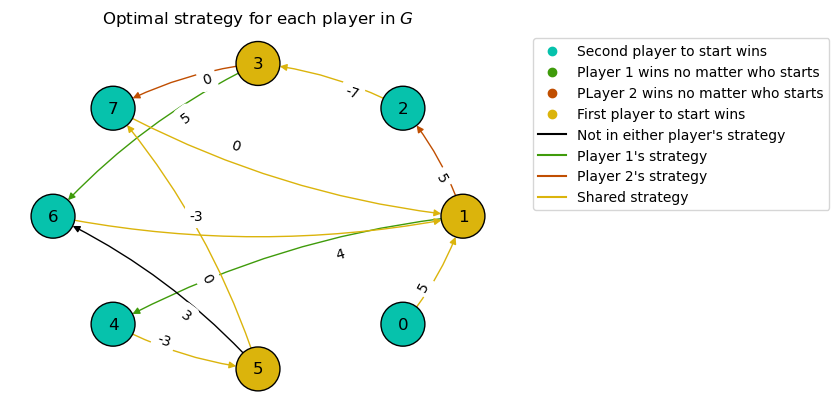

In [55]:
G=mpg.mpg_from_file("data/test01.in",ignore_header=1)
M=MPGVisualisation(G)
M

S=vgame.MPGPlot(M.graph,layout=nx.circular_layout)
S1,S2=mpg.optimal_strategy_pair(S.graph)
S.set_node_color_mapping(vgame.WinnerVisualiser(S.graph,S1,S2))
S.set_edge_color_mapping(vgame.StrategyVisualiser(S1,S2))
fig,ax=figure_mangager.new_subplot("NetworkXPlotExample")
S.plot(ax=ax)
ax.set_title("Optimal strategy for each player in $G$")


# Chapter 2.
## 2.1 Sparse

In [48]:
T=10
N=np.arange(50,1000,10)
C=np.arange(1,11,2)
Z=[]
seed=25
sparse_generator=SparseGraphGenerator("cache/sparse_graphs.csv",T,N,C)
sparse_csv=CSVPayload("cache/sparse_graphs.csv")
sparse_gen=cache_manager.add_loadable("sparse_graphs",sparse_csv,sparse_generator)
sparse_gen=sparse_gen.rename({"C":"expected degree", "N":"vertices"},axis=1)
sparse_gen["time (s)"]=sparse_gen["time"]

Text(0.5, 1.0, 'time to generate a random graph following $\\mathcal{D}^\\bullet\\left(n,\\frac{c}{n}\\right)$')

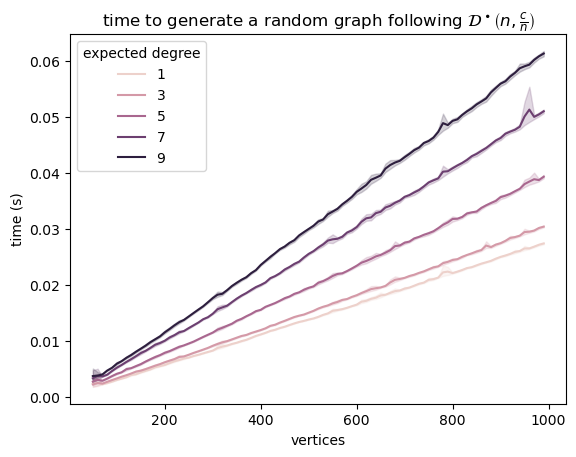

In [49]:
sparse_gen=sparse_gen[sparse_gen["time"]<0.07]
import seaborn as sns
_,ax=figure_mangager.new_subplot("SparseGraphGen")
sns.lineplot(data=sparse_gen,x="vertices",y="time (s)", hue="expected degree",ax=ax)
ax.set_title(R"time to generate a random graph following $\mathcal{D}^\bullet\left(n,\frac{c}{n}\right)$")

## 2.2 Dense

In [50]:

T=10
N=np.arange(50,500,10)
P=[0.05,0.1,0.3,0.5,0.7,0.9,1]
Z=[]
seed=25
dense_generator=DenseGraphGenerator("cache/dense_graphs.csv",T,N,P)
dense_csv=CSVPayload("cache/dense_graphs.csv")
dense_gen=cache_manager.add_loadable("dense_graphs",dense_csv,dense_generator)
dense_gen=dense_gen.rename({"P":"probability", "N":"vertices"},axis=1)
dense_gen["time (s)"]=dense_gen["time"]

Text(0.5, 1.0, 'time to generate a random graph following $\\mathcal{D}^\\bullet(n,p)$')

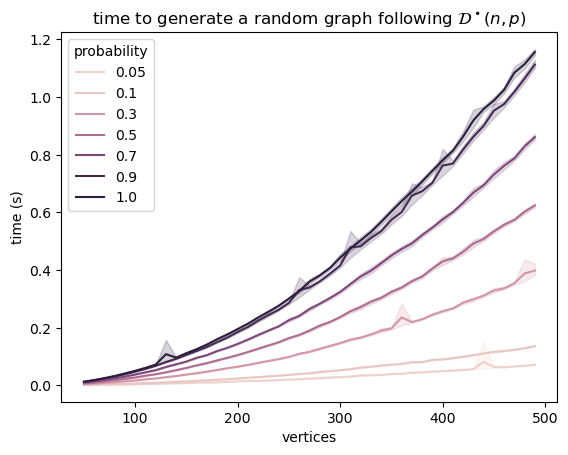

In [51]:
import seaborn as sns
_,ax=figure_mangager.new_subplot("DenseGraphGen")
sns.lineplot(data=dense_gen,x="vertices",y="time (s)", hue="probability",ax=ax,legend="full")
ax.set_title(R"time to generate a random graph following $\mathcal{D}^\bullet(n,p)$")

## 2.3 Combined

Text(0.5, 1.0, 'time to generate a random graph following $\\mathcal{D}^\\bullet(n,p)$')

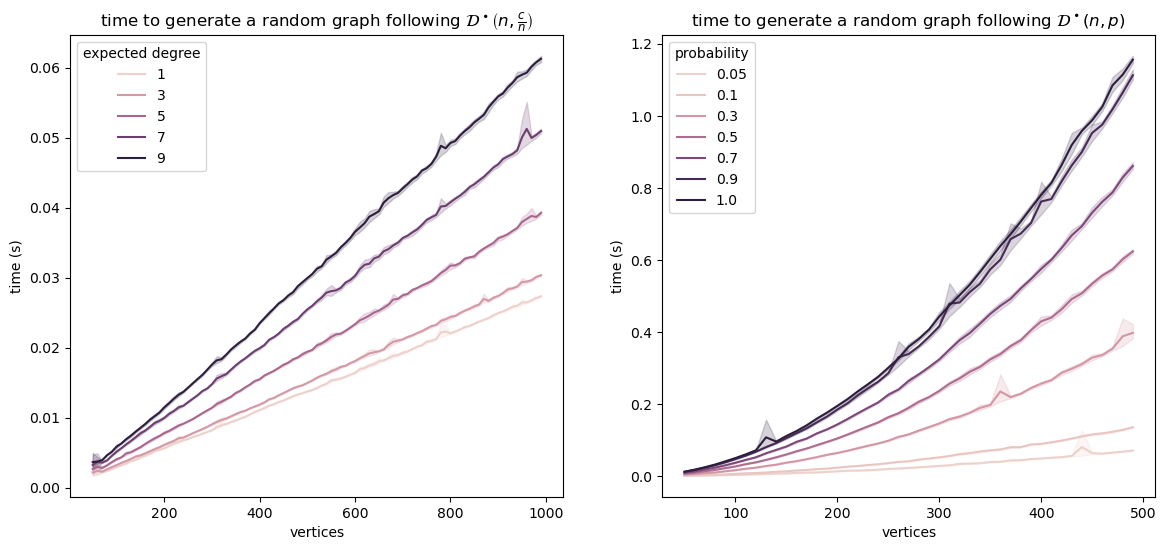

In [46]:
fig,axs=figure_mangager.new_subplot("GraphGen",1,2,figsize=(14,6))
sns.lineplot(data=sparse_gen,x="vertices",y="time (s)", hue="expected degree",ax=axs[0],legend="full")
axs[0].set_title(R"time to generate a random graph following $\mathcal{D}^\bullet\left(n,\frac{c}{n}\right)$")
sns.lineplot(data=dense_gen,x="vertices",y="time (s)", hue="probability",ax=axs[1],legend="full")
axs[1].set_title(R"time to generate a random graph following $\mathcal{D}^\bullet(n,p)$")

## 2.4 Graph Rejection Construction

In [104]:
T=20
N=np.arange(1,20,2)
C=np.arange(1,2,1)
Z=[]
seed=25
sparse_generator_bad=SparseGraphGeneratorBad("cache/bad_sparse_graphs.csv",T,N,C)
sparse_csv_bad=CSVPayload("cache/bad_sparse_graphs.csv")
sparse_gen_bad=cache_manager.add_loadable("bad_sparse_graphs",sparse_csv_bad,sparse_generator_bad)
sparse_gen_bad=sparse_gen_bad.rename({"C":"expected degree", "N":"vertices"},axis=1)
sparse_gen_bad["time (s)"]=sparse_gen_bad["time"]

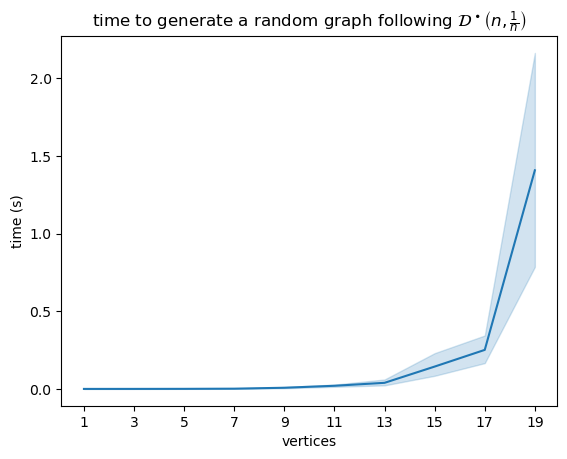

In [106]:
import seaborn as sns
_,ax=figure_mangager.new_subplot("BadSparseGraphGen")
sns.lineplot(data=sparse_gen_bad,x="vertices",y="time (s)",ax=ax)
ax.set_title(R"time to generate a random graph following $\mathcal{D}^\bullet\left(n,\frac{1}{n}\right)$")
new_list = range(1,max(N)+1,2)
ax.set_xticks(new_list);

## 2.5 Degree Rejection

In [128]:
T=10
N=np.arange(50,1000,10)
C=np.arange(1,2,1)
Z=[]
seed=25
sparse_generator_degree=SparseGraphSinkNoSink("cache/degree_sparse_graphs.csv",T,N,C)
sparse_csv_degree=CSVPayload("cache/degree_sparse_graphs.csv")
sparse_gen_degree=cache_manager.add_loadable("degree_sparse_graphs",sparse_csv_degree,sparse_generator_degree)
sparse_gen_degree=sparse_gen_degree.rename({"C":"expected degree", "N":"vertices"},axis=1)
sparse_gen_degree["time (s)"]=sparse_gen_degree["time"]
sparse_gen_degree["time (ms)"]=1000*sparse_gen_degree["time"]

Text(0.5, 1.0, 'time to generate a random graph')

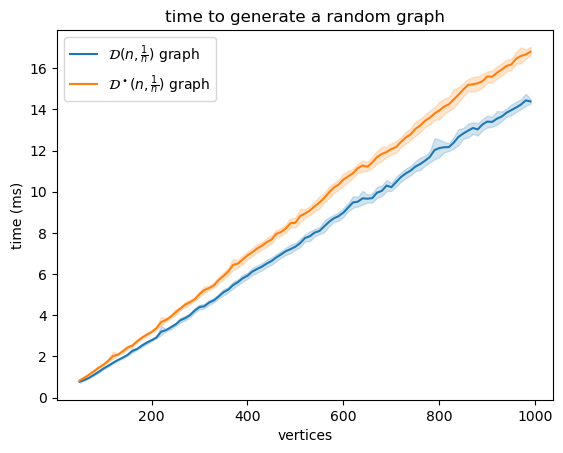

In [131]:
import seaborn as sns
_,ax=figure_mangager.new_subplot("DegreeSparseGraphGen")
sns.lineplot(data=sparse_gen_degree[sparse_gen_degree["sinks"]==True],x="vertices",y="time (ms)",ax=ax,label=R"$\mathcal{D}(n,\frac{1}{n})$ graph")
sns.lineplot(data=sparse_gen_degree[sparse_gen_degree["sinks"]==False],x="vertices",y="time (ms)",ax=ax, label=R"$\mathcal{D}^\bullet(n,\frac{1}{n})$ graph")
theoretical_bound=sparse_gen_degree[sparse_gen_degree["sinks"]==True].copy()

ax.legend()

ax.set_title(R"time to generate a random graph")


# Chapter 3.
## 3.1 Runtime for Sparse Graphs

## 3. Runtime for Dense Graphs

# Export

In [132]:
import os
figure_mangager.save_all("Figures")

In [98]:
sparse_gen

In [7]:
dense_gen

,Unnamed: 0,N,C,time
0,0,50,1,0.006407
1,1,50,3,0.006208
2,2,50,5,0.007913
3,3,50,7,0.009763
4,4,50,9,0.009742
...,...,...,...,...
4745,4745,990,1,0.027746
4746,4746,990,3,0.030914
4747,4747,990,5,0.039418
4748,4748,990,7,0.051644


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 33,
 34]

1